# Combined Simplex Removal: Non-convex + Same-side

This notebook demonstrates removing two types of simplices:
1. **Non-convex** - Adjacent crossing simplices where the SVM boundary is not convex
2. **Same-side** - Sibling simplices that all fall on the same side of the decision boundary


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import sys
import os

current_dir = os.getcwd()
parent_dir = os.path.join(current_dir, '..', '..')
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from in2D.classifying.classes.simplex_tree_classifier import SimplexTreeClassifier
from in2D.classifying.classes.utilss.convexity_check import check_convexity, get_shared_vertices


In [2]:
def make_meshgrid(x, y, h=0.01):
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, xy, **params):
    Z = clf.predict(xy)
    Z = Z.reshape(xx.shape)
    return ax.contourf(xx, yy, Z, **params)


## 1. Create Dataset

In [3]:
data = np.load('dataset.npz')
X, y = data['X'], data['y']

print(f"Dataset: {X.shape[0]} points, Classes: {np.unique(y)}")


Dataset: 790 points, Classes: [-1.  1.]


## 2. Build Model


In [4]:
C = 10000

root_vertices = [
    (0, 0),
    (2, 0),
    (0, 2)
]

subdivision_levels = 4
model = SimplexTreeClassifier(
    vertices=root_vertices,
    regularization=C,
    subdivision_levels=subdivision_levels,
    classifier_type='linear_svc'
)
model.fit(X, y)

x_min, x_max = -0.05, 1.05
y_min, y_max = -0.05, 1.05
xx, yy = make_meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

print(f"Model built with {len(model.leaf_simplexes)} leaf simplices")


(790, 43)
Model built with 81 leaf simplices


## 3. Find Simplices to Remove

- **Non-convex**: Adjacent crossing simplices where the average point falls on wrong side
- **Same-side**: All siblings on same side of decision boundary

In [5]:
weights = model.classifier.coef_[0]
intercept = model.classifier.intercept_[0]
EPSILON = 0.10

nonconvex_simplex_keys = set()
crossing_simplices = model.identify_svm_crossing_simplices()

for i, info1 in enumerate(crossing_simplices):
    simplex1 = info1['simplex']
    for info2 in crossing_simplices[i+1:]:
        simplex2 = info2['simplex']
        shared = get_shared_vertices(simplex1, simplex2)
        if len(shared) >= 2:
            is_convex, avg, meeting, pt1, pt2 = check_convexity(
                simplex1, simplex2, weights, intercept,
                global_tree=model.tree, epsilon=EPSILON
            )
            if not is_convex:
                nonconvex_simplex_keys.add(frozenset(simplex1.vertex_indices))
                nonconvex_simplex_keys.add(frozenset(simplex2.vertex_indices))

# same_side_simplex_keys = []
# nonconvex_simplex_keys = set()

same_side_simplex_keys = model.find_same_side_simplices()
combined_keys = nonconvex_simplex_keys.union(same_side_simplex_keys)

print(f"Non-convex simplices: {len(nonconvex_simplex_keys)}")
print(f"Same-side simplices: {len(same_side_simplex_keys)}")
print(f"Combined (union): {len(combined_keys)}")
print(f"Leaves before removal: {len(model.tree.get_leaves())}")
model.tree.print_tree(show_splitting_points=False)

Non-convex simplices: 24
Same-side simplices: 39
Combined (union): 63
Leaves before removal: 81
└── [0] vertices: [0, 1, 2]
    ├── [1] vertices: [0, 1, 3]
    │   ├── [2] vertices: [0, 1, 4]
    │   │   ├── [3] vertices: [0, 1, 5]
    │   │   │   ├── vertices: [0, 1, 6]
    │   │   │   ├── vertices: [1, 5, 6]
    │   │   │   └── vertices: [5, 0, 6]
    │   │   ├── [4] vertices: [1, 4, 5]
    │   │   │   ├── vertices: [1, 4, 7]
    │   │   │   ├── vertices: [4, 5, 7]
    │   │   │   └── vertices: [5, 1, 7]
    │   │   └── [5] vertices: [4, 0, 5]
    │   │       ├── vertices: [4, 0, 8]
    │   │       ├── vertices: [0, 5, 8]
    │   │       └── vertices: [5, 4, 8]
    │   ├── [6] vertices: [1, 3, 4]
    │   │   ├── [7] vertices: [1, 3, 9]
    │   │   │   ├── vertices: [1, 3, 10]
    │   │   │   ├── vertices: [3, 9, 10]
    │   │   │   └── vertices: [9, 1, 10]
    │   │   ├── [8] vertices: [3, 4, 9]
    │   │   │   ├── vertices: [3, 4, 11]
    │   │   │   ├── vertices: [4, 9, 11]
    │  

## 4. Visualize and Remove

- **Green** = Non-convex only
- **Yellow** = Same-side only
- **Purple** = Both

(790, 43)
Removed 26 simplices
Leaves after removal: 29


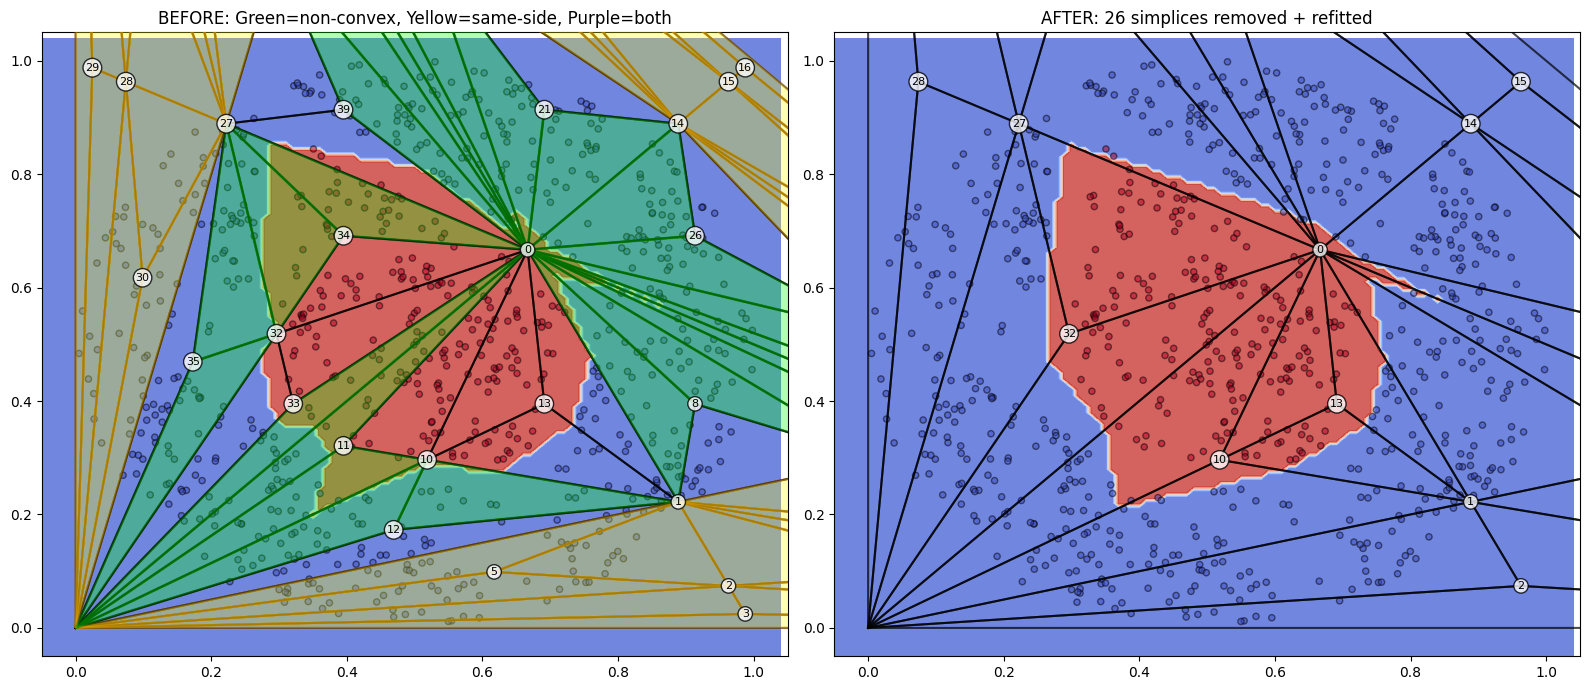

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

ax = axes[0]
xy_before = model.transform(np.vstack([xx.ravel(), yy.ravel()]).T)
plot_contours(ax, model.classifier, xx, yy, xy_before, cmap=plt.cm.coolwarm, alpha=0.8)
for boundary in model.get_simplex_boundaries():
    if len(boundary) >= 3:
        closed = boundary + [boundary[0]]
        bx, by = zip(*closed)
        ax.plot(bx, by, 'k', linestyle='-', linewidth=1.5, alpha=0.7)
for leaf in model.tree.get_leaves():
    simplex_key = frozenset(leaf.vertex_indices)
    is_nonconvex = simplex_key in nonconvex_simplex_keys
    is_same_side = simplex_key in same_side_simplex_keys
    if is_nonconvex and is_same_side:
        color, edge = 'purple', 'darkviolet'
    elif is_nonconvex:
        color, edge = 'lime', 'green'
    elif is_same_side:
        color, edge = 'yellow', 'orange'
    else:
        continue
    vertices = np.array(leaf.vertices)
    poly = patches.Polygon(vertices, closed=True, facecolor=color, alpha=0.3, edgecolor=edge, linewidth=2, zorder=6)
    ax.add_patch(poly)
for idx, center in model.tree.get_splitting_points():
    ax.annotate(str(idx), center, fontsize=8, ha='center', va='center', 
                bbox=dict(boxstyle='circle,pad=0.2', facecolor='white', edgecolor='black', alpha=0.8), zorder=10)
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k', alpha=0.5)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_title("BEFORE: Green=non-convex, Yellow=same-side, Purple=both")

removed_count = 0
for simplex_key in combined_keys:
    if model.tree.remove_by_leaf_key(simplex_key):
        removed_count += 1
model._build_node_lookup()
model.fit(X, y)
print(f"Removed {removed_count} simplices")
print(f"Leaves after removal: {len(model.tree.get_leaves())}")

ax = axes[1]
xy_after = model.transform(np.vstack([xx.ravel(), yy.ravel()]).T)
plot_contours(ax, model.classifier, xx, yy, xy_after, cmap=plt.cm.coolwarm, alpha=0.8)
for leaf in model.tree.get_leaves():
    vertices = leaf.get_vertices_as_tuples()
    if len(vertices) >= 3:
        closed = vertices + [vertices[0]]
        bx, by = zip(*closed)
        ax.plot(bx, by, 'k', linestyle='-', linewidth=1.5, alpha=0.7)
for idx, center in model.tree.get_splitting_points():
    ax.annotate(str(idx), center, fontsize=8, ha='center', va='center', 
                bbox=dict(boxstyle='circle,pad=0.2', facecolor='white', edgecolor='black', alpha=0.8), zorder=10)
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k', alpha=0.5)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_title(f"AFTER: {removed_count} simplices removed + refitted")

plt.tight_layout()
plt.show()


In [7]:
model.tree.print_tree(show_splitting_points=False)

└── [0] vertices: [0, 1, 2]
    ├── [1] vertices: [0, 1, 3]
    │   ├── [2] vertices: [0, 1, 4]
    │   │   ├── vertices: [0, 1, 5]
    │   │   ├── vertices: [1, 4, 5]
    │   │   └── vertices: [4, 0, 5]
    │   ├── [6] vertices: [1, 3, 4]
    │   │   ├── vertices: [1, 3, 9]
    │   │   ├── vertices: [3, 4, 9]
    │   │   └── vertices: [4, 1, 9]
    │   └── [10] vertices: [3, 0, 4]
    │       ├── vertices: [3, 0, 13]
    │       ├── vertices: [0, 4, 13]
    │       └── [13] vertices: [4, 3, 13]
    │           ├── vertices: [4, 3, 16]
    │           ├── vertices: [3, 13, 16]
    │           └── vertices: [13, 4, 16]
    ├── [14] vertices: [1, 2, 3]
    │   ├── [15] vertices: [1, 2, 17]
    │   │   ├── vertices: [1, 2, 18]
    │   │   ├── vertices: [2, 17, 18]
    │   │   └── vertices: [17, 1, 18]
    │   ├── [19] vertices: [2, 3, 17]
    │   │   ├── vertices: [2, 3, 22]
    │   │   ├── vertices: [3, 17, 22]
    │   │   └── vertices: [17, 2, 22]
    │   └── [23] vertices: [3, 1, 17]
 

## 5. Reapply the filters

### Iteration #1

Found: 9 non-convex, 9 same-side, 18 combined


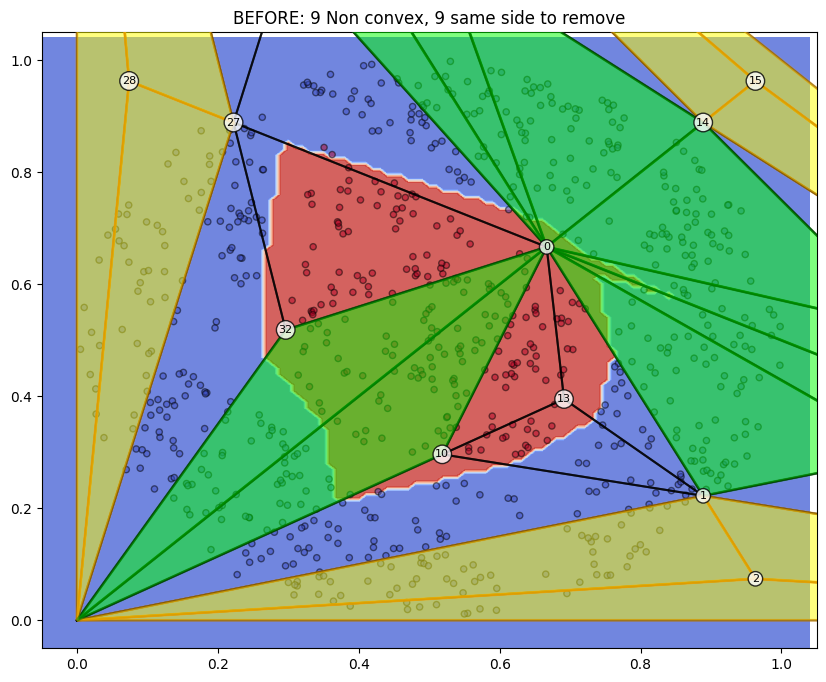

In [8]:
weights = model.classifier.coef_[0]
intercept = model.classifier.intercept_[0]

nonconvex_simplex_keys = set()
crossing_simplices = model.identify_svm_crossing_simplices()
for i, info1 in enumerate(crossing_simplices):
    simplex1 = info1['simplex']
    for info2 in crossing_simplices[i+1:]:
        simplex2 = info2['simplex']
        shared = get_shared_vertices(simplex1, simplex2)
        if len(shared) >= 2:
            is_convex, avg, meeting, pt1, pt2 = check_convexity(
                simplex1, simplex2, weights, intercept,
                global_tree=model.tree, epsilon=EPSILON
            )
            if not is_convex:
                nonconvex_simplex_keys.add(frozenset(simplex1.vertex_indices))
                nonconvex_simplex_keys.add(frozenset(simplex2.vertex_indices))

same_side_simplex_keys = model.find_same_side_simplices()
combined_keys = nonconvex_simplex_keys.union(same_side_simplex_keys)

print(f"Found: {len(nonconvex_simplex_keys)} non-convex, {len(same_side_simplex_keys)} same-side, {len(combined_keys)} combined")

fig, ax = plt.subplots(figsize=(10, 8))
xy = model.transform(np.vstack([xx.ravel(), yy.ravel()]).T)
plot_contours(ax, model.classifier, xx, yy, xy, cmap=plt.cm.coolwarm, alpha=0.8)
for boundary in model.get_simplex_boundaries():
    if len(boundary) >= 3:
        closed = boundary + [boundary[0]]
        bx, by = zip(*closed)
        ax.plot(bx, by, 'k', linestyle='-', linewidth=1.5, alpha=0.7)
for leaf in model.tree.get_leaves():
    simplex_key = frozenset(leaf.vertex_indices)
    is_nonconvex = simplex_key in nonconvex_simplex_keys
    is_same_side = simplex_key in same_side_simplex_keys
    if is_nonconvex and is_same_side:
        color, edge = 'purple', 'darkviolet'
    elif is_nonconvex:
        color, edge = 'lime', 'green'
    elif is_same_side:
        color, edge = 'yellow', 'orange'
    else:
        continue
    vertices = np.array(leaf.vertices)
    poly = patches.Polygon(vertices, closed=True, facecolor=color, alpha=0.5, edgecolor=edge, linewidth=2, zorder=6)
    ax.add_patch(poly)
for idx, center in model.tree.get_splitting_points():
    ax.annotate(str(idx), center, fontsize=8, ha='center', va='center', 
                bbox=dict(boxstyle='circle,pad=0.2', facecolor='white', edgecolor='black', alpha=0.8), zorder=10)
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k', alpha=0.5)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_title(f"BEFORE: {len(nonconvex_simplex_keys)} Non convex, {len(same_side_simplex_keys)} same side to remove")
plt.show()

(790, 43)
Removed 8. Leaves remaining: 13


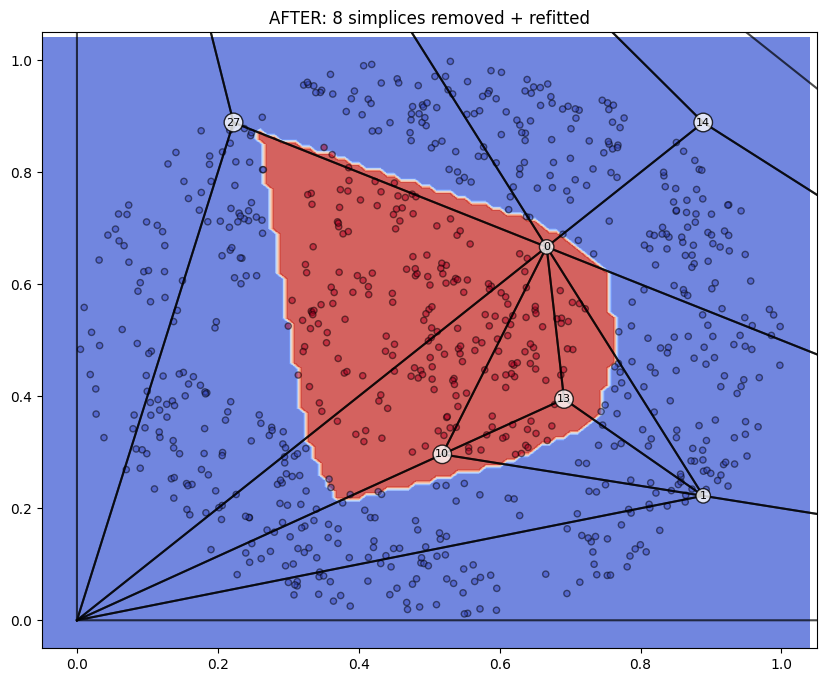

In [9]:
if len(combined_keys) > 0:
    removed_count = 0
    for simplex_key in combined_keys:
        if model.tree.remove_by_leaf_key(simplex_key):
            removed_count += 1
    model._build_node_lookup()
    model.fit(X, y)
    print(f"Removed {removed_count}. Leaves remaining: {len(model.tree.get_leaves())}")
    
    fig, ax = plt.subplots(figsize=(10, 8))
    xy = model.transform(np.vstack([xx.ravel(), yy.ravel()]).T)
    plot_contours(ax, model.classifier, xx, yy, xy, cmap=plt.cm.coolwarm, alpha=0.8)
    for leaf in model.tree.get_leaves():
        vertices = leaf.get_vertices_as_tuples()
        if len(vertices) >= 3:
            closed = vertices + [vertices[0]]
            bx, by = zip(*closed)
            ax.plot(bx, by, 'k', linestyle='-', linewidth=1.5, alpha=0.7)
    for idx, center in model.tree.get_splitting_points():
        ax.annotate(str(idx), center, fontsize=8, ha='center', va='center', 
                    bbox=dict(boxstyle='circle,pad=0.2', facecolor='white', edgecolor='black', alpha=0.8), zorder=10)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k', alpha=0.5)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_title(f"AFTER: {removed_count} simplices removed + refitted")
    plt.show()
else:
    print("Nothing to remove - converged!")

### Iteration #2

Found: 0 non-convex, 0 same-side, 0 combined


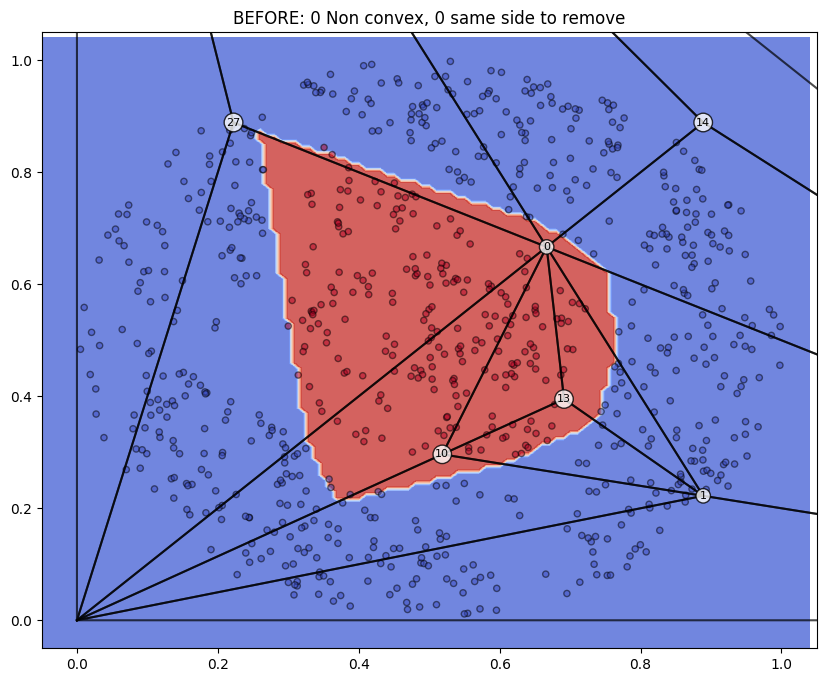

In [10]:
weights = model.classifier.coef_[0]
intercept = model.classifier.intercept_[0]

nonconvex_simplex_keys = set()
crossing_simplices = model.identify_svm_crossing_simplices()
for i, info1 in enumerate(crossing_simplices):
    simplex1 = info1['simplex']
    for info2 in crossing_simplices[i+1:]:
        simplex2 = info2['simplex']
        shared = get_shared_vertices(simplex1, simplex2)
        if len(shared) >= 2:
            is_convex, avg, meeting, pt1, pt2 = check_convexity(
                simplex1, simplex2, weights, intercept,
                global_tree=model.tree, epsilon=EPSILON
            )
            if not is_convex:
                nonconvex_simplex_keys.add(frozenset(simplex1.vertex_indices))
                nonconvex_simplex_keys.add(frozenset(simplex2.vertex_indices))

same_side_simplex_keys = model.find_same_side_simplices()
combined_keys = nonconvex_simplex_keys.union(same_side_simplex_keys)

print(f"Found: {len(nonconvex_simplex_keys)} non-convex, {len(same_side_simplex_keys)} same-side, {len(combined_keys)} combined")

fig, ax = plt.subplots(figsize=(10, 8))
xy = model.transform(np.vstack([xx.ravel(), yy.ravel()]).T)
plot_contours(ax, model.classifier, xx, yy, xy, cmap=plt.cm.coolwarm, alpha=0.8)
for boundary in model.get_simplex_boundaries():
    if len(boundary) >= 3:
        closed = boundary + [boundary[0]]
        bx, by = zip(*closed)
        ax.plot(bx, by, 'k', linestyle='-', linewidth=1.5, alpha=0.7)
for leaf in model.tree.get_leaves():
    simplex_key = frozenset(leaf.vertex_indices)
    is_nonconvex = simplex_key in nonconvex_simplex_keys
    is_same_side = simplex_key in same_side_simplex_keys
    if is_nonconvex and is_same_side:
        color, edge = 'purple', 'darkviolet'
    elif is_nonconvex:
        color, edge = 'lime', 'green'
    elif is_same_side:
        color, edge = 'yellow', 'orange'
    else:
        continue
    vertices = np.array(leaf.vertices)
    poly = patches.Polygon(vertices, closed=True, facecolor=color, alpha=0.5, edgecolor=edge, linewidth=2, zorder=6)
    ax.add_patch(poly)
for idx, center in model.tree.get_splitting_points():
    ax.annotate(str(idx), center, fontsize=8, ha='center', va='center', 
                bbox=dict(boxstyle='circle,pad=0.2', facecolor='white', edgecolor='black', alpha=0.8), zorder=10)
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k', alpha=0.5)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_title(f"BEFORE: {len(nonconvex_simplex_keys)} Non convex, {len(same_side_simplex_keys)} same side to remove")
plt.show()

In [11]:
if len(combined_keys) > 0:
    removed_count = 0
    for simplex_key in combined_keys:
        if model.tree.remove_by_leaf_key(simplex_key):
            removed_count += 1
    model._build_node_lookup()
    model.fit(X, y)
    print(f"Removed {removed_count}. Leaves remaining: {len(model.tree.get_leaves())}")
    
    fig, ax = plt.subplots(figsize=(10, 8))
    xy = model.transform(np.vstack([xx.ravel(), yy.ravel()]).T)
    plot_contours(ax, model.classifier, xx, yy, xy, cmap=plt.cm.coolwarm, alpha=0.8)
    for leaf in model.tree.get_leaves():
        vertices = leaf.get_vertices_as_tuples()
        if len(vertices) >= 3:
            closed = vertices + [vertices[0]]
            bx, by = zip(*closed)
            ax.plot(bx, by, 'k', linestyle='-', linewidth=1.5, alpha=0.7)
    for idx, center in model.tree.get_splitting_points():
        ax.annotate(str(idx), center, fontsize=8, ha='center', va='center', 
                    bbox=dict(boxstyle='circle,pad=0.2', facecolor='white', edgecolor='black', alpha=0.8), zorder=10)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k', alpha=0.5)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_title(f"AFTER: {removed_count} simplices removed + refitted")
    plt.show()
else:
    print("Nothing to remove - converged!")

Nothing to remove - converged!


### Iteration #3

Found: 0 non-convex, 0 same-side, 0 combined


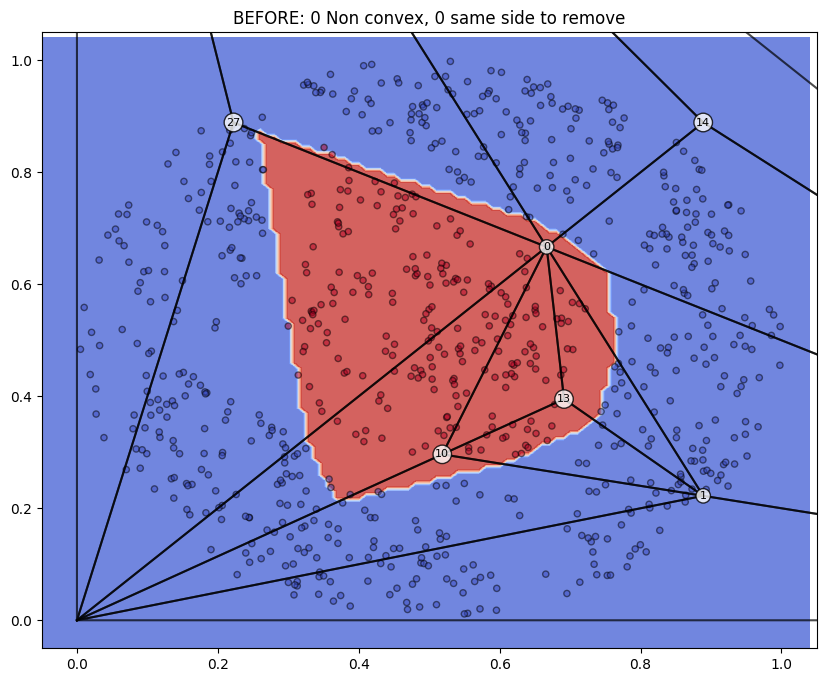

In [12]:
weights = model.classifier.coef_[0]
intercept = model.classifier.intercept_[0]

nonconvex_simplex_keys = set()
crossing_simplices = model.identify_svm_crossing_simplices()
for i, info1 in enumerate(crossing_simplices):
    simplex1 = info1['simplex']
    for info2 in crossing_simplices[i+1:]:
        simplex2 = info2['simplex']
        shared = get_shared_vertices(simplex1, simplex2)
        if len(shared) >= 2:
            is_convex, avg, meeting, pt1, pt2 = check_convexity(
                simplex1, simplex2, weights, intercept,
                global_tree=model.tree, epsilon=EPSILON
            )
            if not is_convex:
                nonconvex_simplex_keys.add(frozenset(simplex1.vertex_indices))
                nonconvex_simplex_keys.add(frozenset(simplex2.vertex_indices))

same_side_simplex_keys = model.find_same_side_simplices()
combined_keys = nonconvex_simplex_keys.union(same_side_simplex_keys)

print(f"Found: {len(nonconvex_simplex_keys)} non-convex, {len(same_side_simplex_keys)} same-side, {len(combined_keys)} combined")

fig, ax = plt.subplots(figsize=(10, 8))
xy = model.transform(np.vstack([xx.ravel(), yy.ravel()]).T)
plot_contours(ax, model.classifier, xx, yy, xy, cmap=plt.cm.coolwarm, alpha=0.8)
for boundary in model.get_simplex_boundaries():
    if len(boundary) >= 3:
        closed = boundary + [boundary[0]]
        bx, by = zip(*closed)
        ax.plot(bx, by, 'k', linestyle='-', linewidth=1.5, alpha=0.7)
for leaf in model.tree.get_leaves():
    simplex_key = frozenset(leaf.vertex_indices)
    is_nonconvex = simplex_key in nonconvex_simplex_keys
    is_same_side = simplex_key in same_side_simplex_keys
    if is_nonconvex and is_same_side:
        color, edge = 'purple', 'darkviolet'
    elif is_nonconvex:
        color, edge = 'lime', 'green'
    elif is_same_side:
        color, edge = 'yellow', 'orange'
    else:
        continue
    vertices = np.array(leaf.vertices)
    poly = patches.Polygon(vertices, closed=True, facecolor=color, alpha=0.5, edgecolor=edge, linewidth=2, zorder=6)
    ax.add_patch(poly)
for idx, center in model.tree.get_splitting_points():
    ax.annotate(str(idx), center, fontsize=8, ha='center', va='center', 
                bbox=dict(boxstyle='circle,pad=0.2', facecolor='white', edgecolor='black', alpha=0.8), zorder=10)
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k', alpha=0.5)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_title(f"BEFORE: {len(nonconvex_simplex_keys)} Non convex, {len(same_side_simplex_keys)} same side to remove")
plt.show()

In [13]:
if len(combined_keys) > 0:
    removed_count = 0
    for simplex_key in combined_keys:
        if model.tree.remove_by_leaf_key(simplex_key):
            removed_count += 1
    model._build_node_lookup()
    model.fit(X, y)
    print(f"Removed {removed_count}. Leaves remaining: {len(model.tree.get_leaves())}")
    
    fig, ax = plt.subplots(figsize=(10, 8))
    xy = model.transform(np.vstack([xx.ravel(), yy.ravel()]).T)
    plot_contours(ax, model.classifier, xx, yy, xy, cmap=plt.cm.coolwarm, alpha=0.8)
    for leaf in model.tree.get_leaves():
        vertices = leaf.get_vertices_as_tuples()
        if len(vertices) >= 3:
            closed = vertices + [vertices[0]]
            bx, by = zip(*closed)
            ax.plot(bx, by, 'k', linestyle='-', linewidth=1.5, alpha=0.7)
    for idx, center in model.tree.get_splitting_points():
        ax.annotate(str(idx), center, fontsize=8, ha='center', va='center', 
                    bbox=dict(boxstyle='circle,pad=0.2', facecolor='white', edgecolor='black', alpha=0.8), zorder=10)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k', alpha=0.5)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_title(f"AFTER: {removed_count} simplices removed + refitted")
    plt.show()
else:
    print("Nothing to remove - converged!")

Nothing to remove - converged!


In [14]:
model.tree.print_tree(show_splitting_points=False)

└── [0] vertices: [0, 1, 2]
    ├── [1] vertices: [0, 1, 3]
    │   ├── vertices: [0, 1, 4]
    │   ├── vertices: [1, 3, 4]
    │   └── [10] vertices: [3, 0, 4]
    │       ├── vertices: [3, 0, 13]
    │       ├── vertices: [0, 4, 13]
    │       └── [13] vertices: [4, 3, 13]
    │           ├── vertices: [4, 3, 16]
    │           ├── vertices: [3, 13, 16]
    │           └── vertices: [13, 4, 16]
    ├── [14] vertices: [1, 2, 3]
    │   ├── vertices: [1, 2, 17]
    │   ├── vertices: [2, 3, 17]
    │   └── vertices: [3, 1, 17]
    └── [27] vertices: [2, 0, 3]
        ├── vertices: [2, 0, 30]
        ├── vertices: [0, 3, 30]
        └── vertices: [3, 2, 30]
